# Images and filters

Topics:
- Gaussian LPF
- Moving average LPF
- HPF 
- Crispening
- ARMA (auto-regressive moving average) [to be fixed]
- ROF: min-max-median filters [to be implemented]

Text(0.5, 1.0, 'crispening filter 3x3 result')

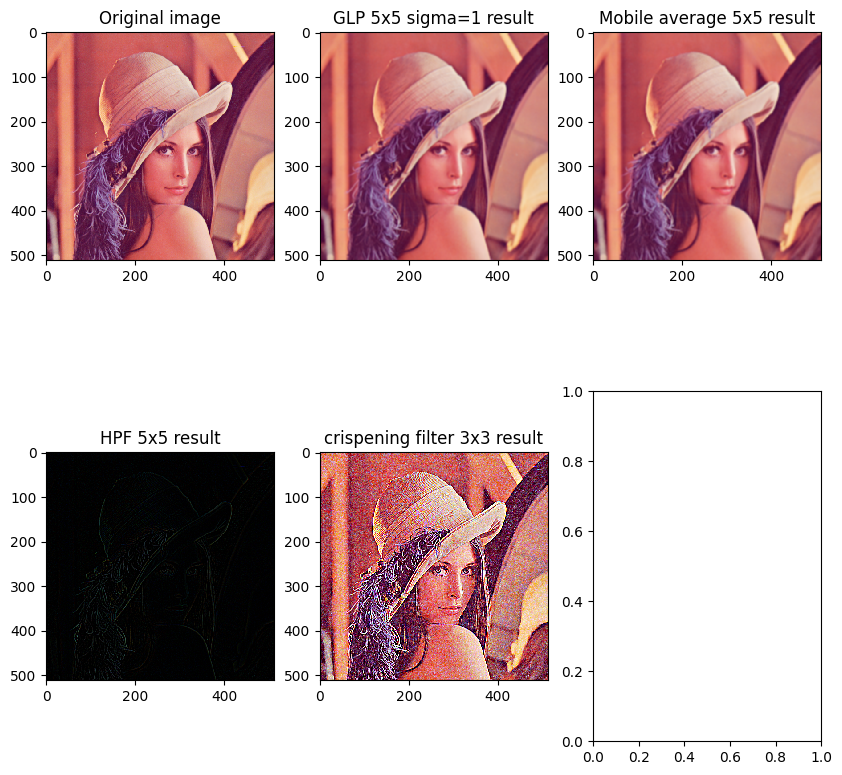

In [2]:
from math import floor
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def return_rgb_image(image: np.ndarray) -> np.ndarray:
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def gaussian_norm_kernel(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

def arma_filter(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:

    ks = floor(kernel.shape[0]/2)
    ls = floor(kernel.shape[1]/2)

    for m in range(ks, image.shape[0]-ks):
        for n in range(ls, image.shape[1]-ls):
            tmp = 0
            #image[m, n] = np.sum(image[m-ks:m+ks+1, n-ls:n+ls+1]*kernel)
            for k in range(-ks, ks):
                for l in range(-ls, ls):
                    tmp += image[m+k, n+l]*kernel[ks+k, ls+l]
            image[m,n]=tmp
    
    return image

image = cv.imread('lena.png')
if image is None:
    print('Could not read image')

fig, xarr = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
xarr[0,0].imshow(return_rgb_image(image), interpolation='nearest')
xarr[0,0].set_title("Original image")

# gaussian normalized kernel
GAUSSIAN_LPF_WIDTH_X = 5
GAUSSIAN_LPF_WIDTH_Y = 5
GAUSSIAN_LPF_SIGMA = 1
gaussian_normalized_kernel = gaussian_norm_kernel(GAUSSIAN_LPF_WIDTH_X, 1)
gaussian_normalized_result = cv.filter2D(src=image, ddepth=-1, kernel=gaussian_normalized_kernel)

xarr[0,1].imshow(return_rgb_image(gaussian_normalized_result), interpolation='nearest')
xarr[0,1].set_title(f'GLP {GAUSSIAN_LPF_WIDTH_X}x{GAUSSIAN_LPF_WIDTH_X} sigma={GAUSSIAN_LPF_SIGMA} result')

# mobile mean kernel
MOVING_AVERAGE_WIDTH_X = 5
MOVING_AVERAGE_WIDTH_Y = 5
moving_average_kernel = np.ones((MOVING_AVERAGE_WIDTH_X, MOVING_AVERAGE_WIDTH_Y), np.float32) / (MOVING_AVERAGE_WIDTH_X*MOVING_AVERAGE_WIDTH_Y)
moving_average_result = cv.filter2D(src=image, ddepth=-1, kernel=moving_average_kernel)

xarr[0,2].imshow(return_rgb_image(moving_average_result), interpolation='nearest')
xarr[0,2].set_title(f'Mobile average {MOVING_AVERAGE_WIDTH_X}x{MOVING_AVERAGE_WIDTH_Y} result')

# creating high pass filter starting from a all pass filter
ALL_PASS_WIDTH_X = 5
ALL_PASS_WIDTH_Y = 5
all_pass_kernel = np.zeros(shape=(ALL_PASS_WIDTH_X, ALL_PASS_WIDTH_Y), dtype=np.float32)
all_pass_kernel[ALL_PASS_WIDTH_X//2, ALL_PASS_WIDTH_Y//2] = 1
# high pass filter is the difference between all pass and moving average LPF
support_moving_average = (np.ones(shape=(ALL_PASS_WIDTH_X, ALL_PASS_WIDTH_Y), dtype=np.float32) / (ALL_PASS_WIDTH_X*ALL_PASS_WIDTH_Y))
high_pass_kernel = all_pass_kernel - support_moving_average
high_pass_result = cv.filter2D(src=image, ddepth=-1, kernel=high_pass_kernel)

xarr[1,0].imshow(return_rgb_image(high_pass_result), interpolation='nearest')
xarr[1,0].set_title(f'HPF {ALL_PASS_WIDTH_X}x{ALL_PASS_WIDTH_Y} result')

# example of crispening filter
CRISPENING_WIDTH_XY = 3
crispening_kernel = np.ones(shape=(CRISPENING_WIDTH_XY, CRISPENING_WIDTH_XY), dtype=np.float32)*(-1)
crispening_kernel[CRISPENING_WIDTH_XY//2, CRISPENING_WIDTH_XY//2] = CRISPENING_WIDTH_XY**2
crispening_result = cv.filter2D(src=image, ddepth=-1, kernel=crispening_kernel)
xarr[1,1].imshow(return_rgb_image(crispening_result), interpolation='nearest')
xarr[1,1].set_title(f'crispening filter {CRISPENING_WIDTH_XY}x{CRISPENING_WIDTH_XY} result')

# arma filter
# arma_result = arma_filter(image, moving_average_kernel)
# xarr[1,2].imshow(return_rgb_image(arma_result), interpolation='nearest')
xarr[1,2].set_title(f'ARMA {MOVING_AVERAGE_WIDTH_X}x{MOVING_AVERAGE_WIDTH_Y} result')